# Metadata

Model number of shootings per state given political spending by party in a given state.  

Data Sources: 

    Gun Violence Awareness  
    Political Media Spending (3rd party) from 2020 Presidential General Election

Modeling based on the following:  
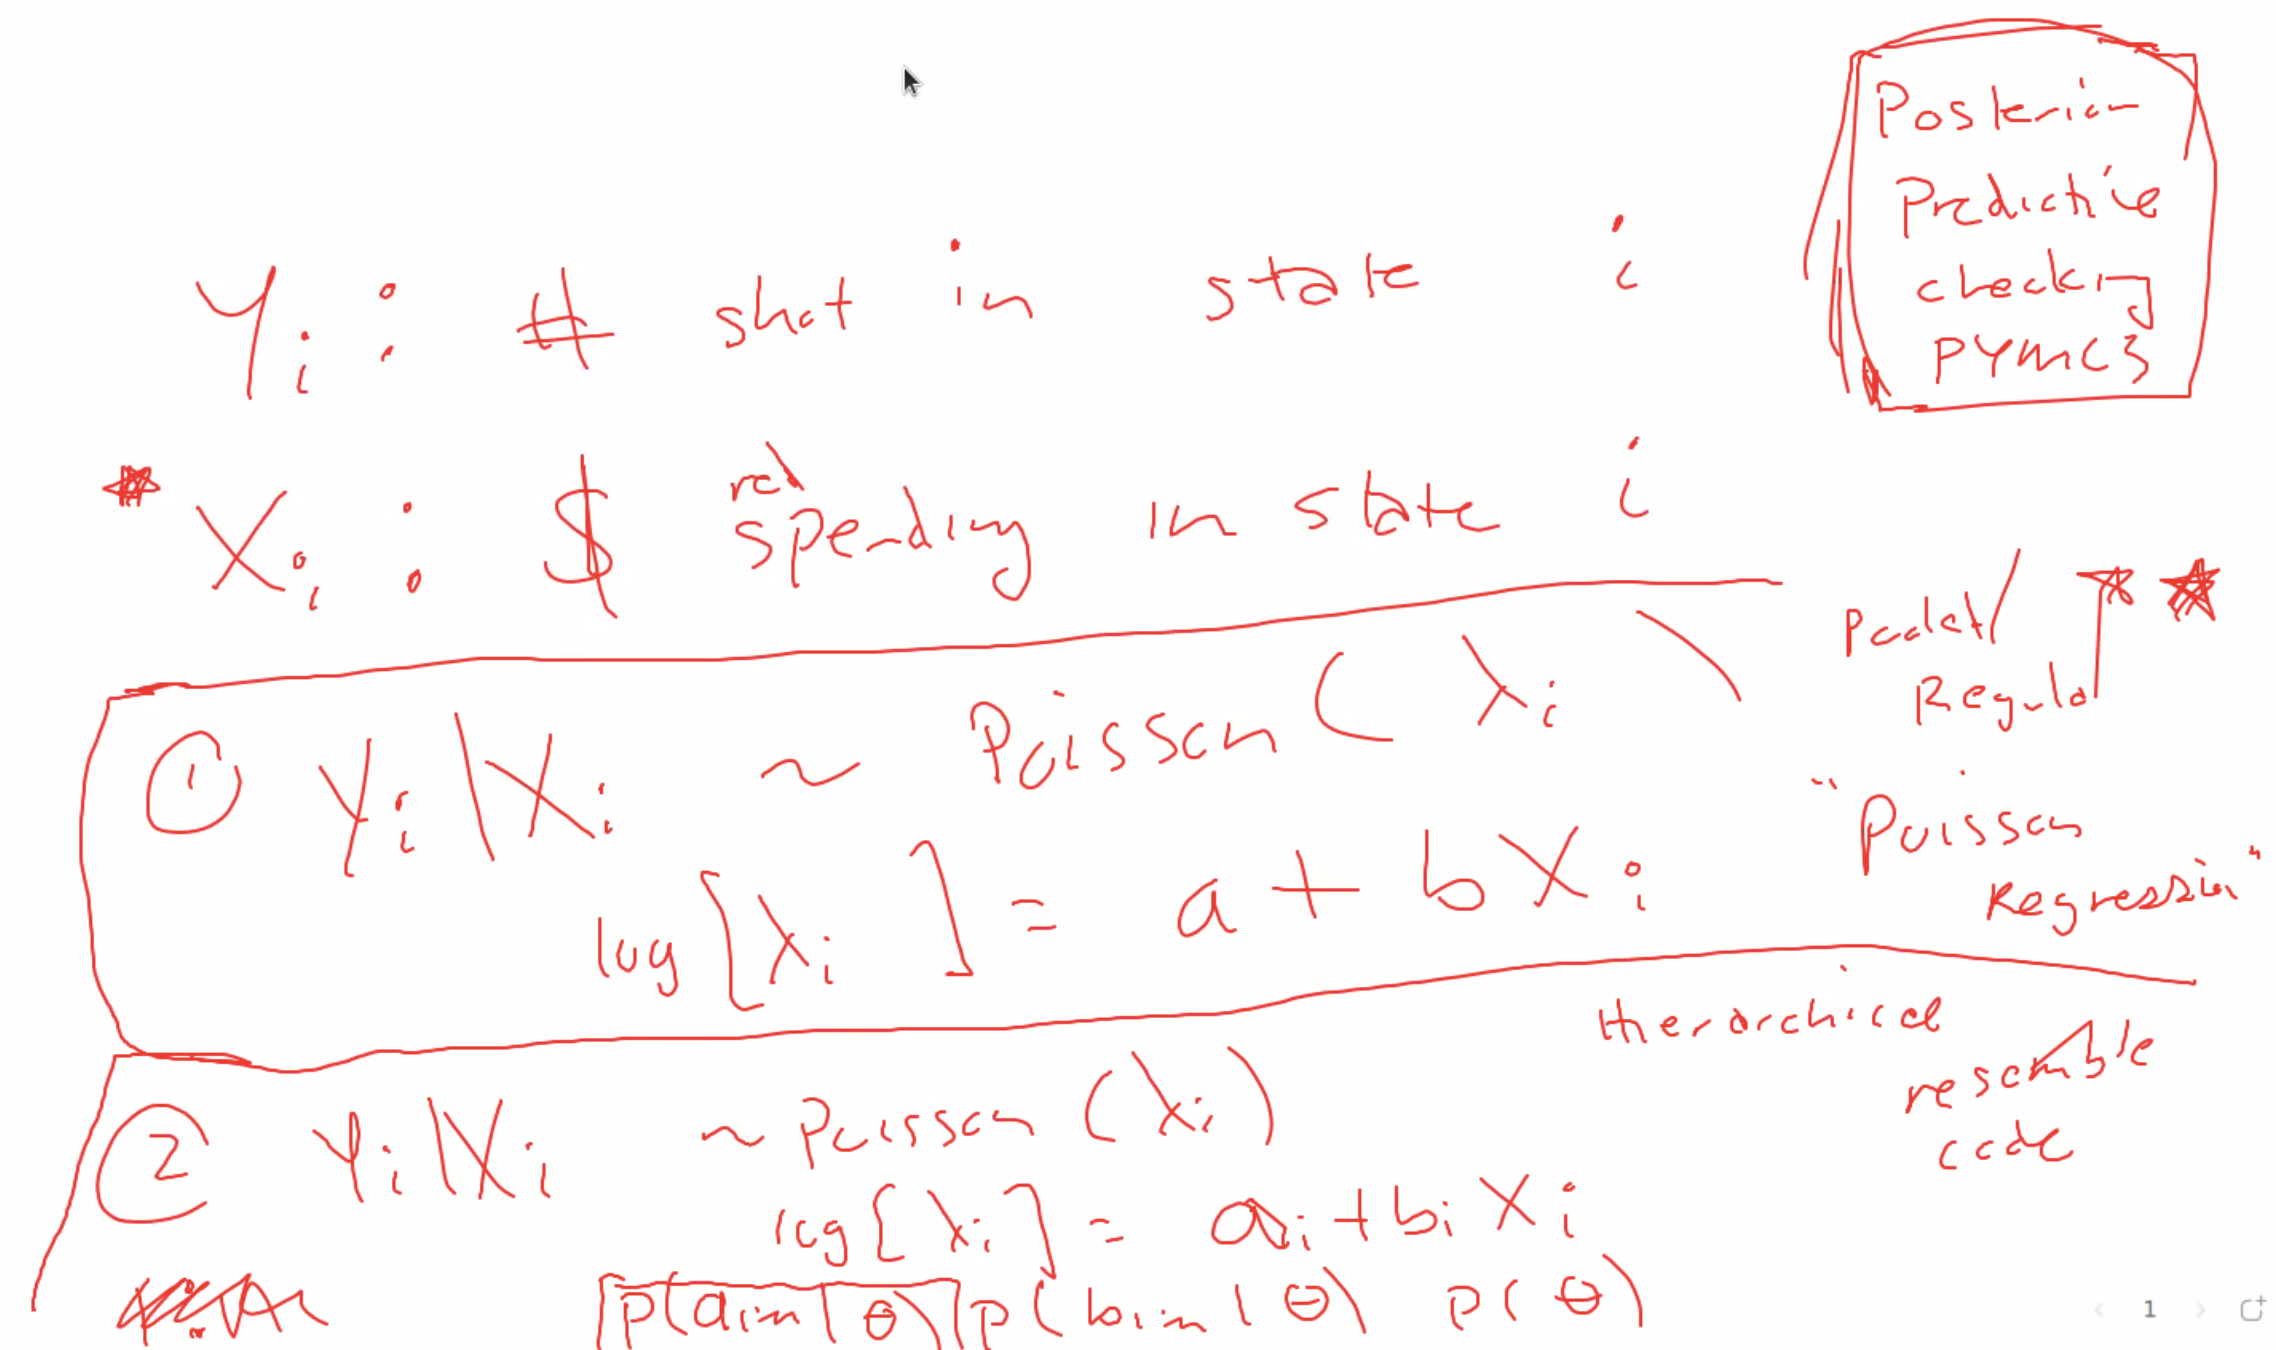

Poisson distribution is useful when counting things. In this case, we're counting the number of victims in all shootings (from 2020 to 7/8/22) for each state. Model requires using discrete non-negative numbers: {0,1,2,3...} (aka count data).

https://learning.oreilly.com/library/view/bayesian-analysis-with/9781789341652/2252e56c-3e2d-40ae-812b-38a5bd4e63d2.xhtml

https://www.youtube.com/watch?v=ZxR3mw-Znzc

Workflow:  
1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence (cool stuff?)
6. Run posterior predictive check
7. Improve model


In [1]:
#import libraries
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from formulae import design_matrices
import arviz as az
import bambi as bmb
import math

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
df = pd.read_csv("state_level_data.csv")
party = pd.read_csv("presidential_state_results_2020.csv")

In [3]:
#df.columns

In [4]:
#party

In [5]:
#drop index column
df = df[['state', 'total_involved', 'abbrev', 'democrat','republican']]

In [6]:
#add column for red/blue state (visualization purposes only)
df = df.join(other = party.set_index('state'), on = 'abbrev', how = 'left')

## Difference in spending New Variable
+ If positive, more Dem spending
+ if negative, more Rep spending 

In [7]:
#add in difference in dem / repub try as predictor
df['party_spending_differences'] = df.democrat - df.republican
#df

In [8]:
#marker for higher repub spending 
df['higher_rep_spend'] = [x<0 for x in df.party_spending_differences]
df['party_with_higher_spend'] = ['rep' if x<0 else 'dem' for x in df.party_spending_differences]
#df

In [9]:
#now take absolute value -> so can transform with log
df['abs_spend_diff']=[abs(x) for x in df.party_spending_differences]
#df

In [10]:
df['log_diff'] = [np.log(x) for x in df['abs_spend_diff']] 

In [11]:
df['log_rep'] = [np.log(x) for x in df['republican']] 

In [12]:
df['log_inv'] = [np.log(x) for x in df['total_involved']] 

In [13]:
df

,state,total_involved,abbrev,democrat,republican,party,party_spending_differences,higher_rep_spend,party_with_higher_spend,abs_spend_diff,log_diff,log_rep,log_inv
0,Alabama,195,AL,3.847529e+05,1.336843e+06,r,-9.520898e+05,True,rep,9.520898e+05,13.766415,14.105821,5.273000
1,Alaska,18,AK,9.699815e+04,2.169688e+05,r,-1.199707e+05,True,rep,1.199707e+05,11.695003,12.287509,2.890372
2,Arizona,106,AZ,9.079025e+07,6.144790e+07,b,2.934235e+07,False,dem,2.934235e+07,17.194542,17.933700,4.663439
3,Arkansas,127,AR,3.368742e+05,5.981153e+05,r,-2.612411e+05,True,rep,2.612411e+05,12.473199,13.301539,4.844187
4,California,557,CA,1.067421e+07,8.769293e+06,b,1.904918e+06,False,dem,1.904918e+06,14.459949,15.986767,6.322565
5,Colorado,168,CO,4.200255e+06,1.118881e+06,b,3.081373e+06,False,dem,3.081373e+06,14.940886,13.927840,5.123964
6,Connecticut,50,CT,5.880892e+05,3.885284e+05,b,1.995608e+05,False,dem,1.995608e+05,12.203874,12.870121,3.912023
7,Delaware,43,DE,2.135545e+05,1.185754e+05,b,9.497903e+04,False,dem,9.497903e+04,11.461411,11.683305,3.761200
8,District of Columbia,156,DC,7.453544e+06,2.962742e+06,b,4.490802e+06,False,dem,4.490802e+06,15.317542,14.901626,5.049856
9,Florida,413,FL,2.289976e+08,1.205918e+08,r,1.084058e+08,False,dem,1.084058e+08,18.501393,18.607922,6.023448


In [14]:
#average number of people involved in shooting per state
mean = np.average(df['total_involved'])

In [15]:
#calculate 3 sigma
sigma3np = np.std(df['total_involved'])*3 + mean
sigma3pd = df['total_involved'].std()*3 + mean

In [16]:
df[df['total_involved'] > sigma3np]

,state,total_involved,abbrev,democrat,republican,party,party_spending_differences,higher_rep_spend,party_with_higher_spend,abs_spend_diff,log_diff,log_rep,log_inv
12,Illinois,948,IL,2040903.14,1605249.41,b,435653.73,False,dem,435653.73,12.984603,14.28879,6.854355


In [17]:
#average number of people involved in shooting per state
meanlog = np.average(df['log_inv'])

In [18]:
#calculate 3 sigma
sigma3nplog = np.std(df['log_inv'])*3 + meanlog
sigma3pdlog = df['log_inv'].std()*3 + meanlog
#calculate 2 sigma
sigma2nplog = np.std(df['log_inv'])*2 + meanlog
sigma2pdlog = df['log_inv'].std()*2 + meanlog

In [19]:
meanlog, sigma3nplog, sigma3pdlog

(4.5253278511100685, 8.608881319904052, 8.654004827508658)

In [20]:
meanlog, sigma2nplog, sigma2pdlog

(4.5253278511100685, 7.247696830306058, 7.277779168709129)

In [21]:
#remove Illinois as an outlier
df_noutlier = df.loc[~df['state'].isin(['Illinois'])]

In [22]:
#df.shape, df_noutlier.shape

In [23]:
#save df with party info
#df.to_csv('state_spending_with_party.csv')

# 1. Plot Data

## Republican Spending against Total Involved

Text(0, 0.5, 'Total Number of People Involved')

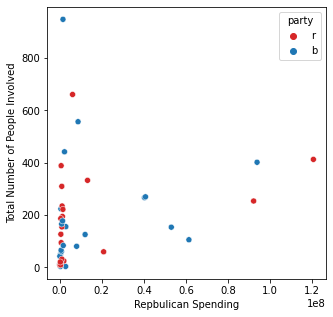

In [24]:
#regular variables (no transformation)
#define palette colors
palette = {'b':'tab:blue',
          'r':'tab:red'}

#scatterplot
plt.figure(figsize = (5,5))
sns.scatterplot(data = df, 
                x = 'republican',
                y = 'total_involved',
                hue = 'party',
               palette = palette)
plt.xlabel('Repbulican Spending')
plt.ylabel('Total Number of People Involved')
#plt.title('Total Number of Involved in Shooting against Republican Spending (per State)')
#plt.show()

Text(0, 0.5, 'Log of Total Number of People Involved')

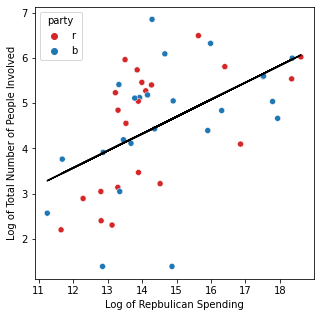

In [25]:
#log transformed variables
#define palette colors
palette = {'b':'tab:blue',
          'r':'tab:red'}

#define variables
x = df['log_rep']
y = df['log_inv']

#scatterplot
plt.figure(figsize = (5,5))
m, b = np.polyfit(x, y, 1)
sns.scatterplot(data = df, 
                x = x, 
                y = y,
                hue = 'party',
               palette = palette)

#add linear regression line
plt.plot(x, m*x+b, color = 'black')

#add axis labels
plt.xlabel('Log of Repbulican Spending')
plt.ylabel('Log of Total Number of People Involved')

Will use log transformations because they satisfy linearity requirement

## Difference in Spending against Total Involved

Text(0, 0.5, 'Total Number of People Involved')

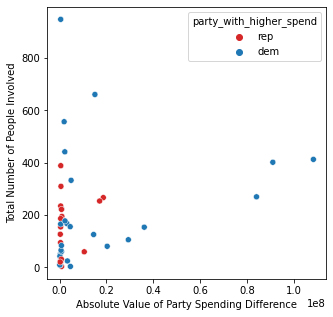

In [26]:
#define palette colors
palette = {'dem':'tab:blue',
          'rep':'tab:red'}

#define variables
x = df['abs_spend_diff']
y = df['total_involved']

#scatterplot
plt.figure(figsize = (5,5))
m, b = np.polyfit(x, y, 1)
sns.scatterplot(data = df, 
                #x = 'abs_spend_diff',
                x = x,
                #y = 'total_involved',
                y = y,
                hue = 'party_with_higher_spend',
               palette = palette)

#plot linear regression line
#plt.plot(x, m*x+b, color = 'black')

#change axis labels
plt.xlabel('Absolute Value of Party Spending Difference')
plt.ylabel('Total Number of People Involved')

Text(0, 0.5, 'Log of Total Number People Involved')

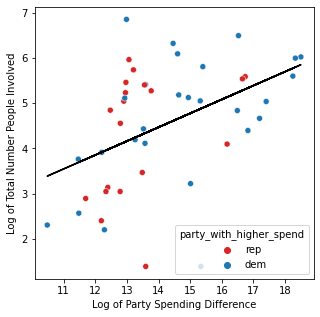

In [27]:
#define palette colors
palette = {'dem':'tab:blue',
          'rep':'tab:red'}

#define variables
x = df['log_diff']
y = df['log_inv']

#scatterplot
plt.figure(figsize = (5,5))
m, b = np.polyfit(x, y, 1)
sns.scatterplot(data = df, 
                #x = 'abs_spend_diff',
                x = x,
                #y = 'total_involved',
                y = y,
                hue = 'party_with_higher_spend',
               palette = palette)

#plot linear regression line
plt.plot(x, m*x+b, color = 'black')

#change axis labels
plt.xlabel('Log of Party Spending Difference')
plt.ylabel('Log of Total Number People Involved')


#add text labels
# for i in range(df.shape[0]):
#     if df.party_spending_differences[i] > 0.2e8:
#         plt.text(x = df.republican[i]+5,
#                 y = df.total_involved[i]+15,
#                 s = df.state[i],
#                 fontdict=dict(color = 'black', size = 10))

Again, use log transformed variables to meet linearity requirement

## Histogram flots to observe frequency

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

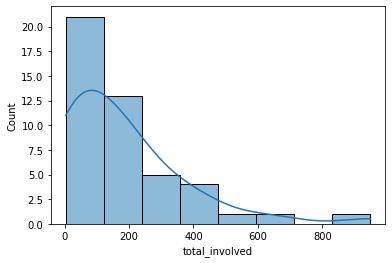

In [28]:
sns.histplot(data = df, x = 'total_involved', kde = True)

<AxesSubplot:xlabel='log_inv', ylabel='Count'>

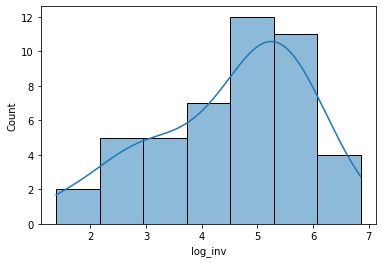

In [29]:
sns.histplot(data = df, x = 'log_inv', kde = True)

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

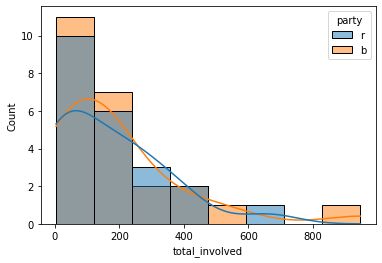

In [30]:
sns.histplot(data = df, x = 'total_involved', kde = True, hue = 'party')

<AxesSubplot:xlabel='log_inv', ylabel='Count'>

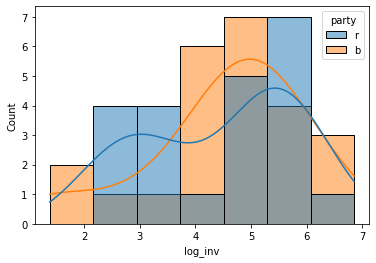

In [31]:
sns.histplot(data = df, x = 'log_inv', kde = True, hue = 'party')

# 2. Build Model

The probability mass function of Poisson distribution is as follows:  

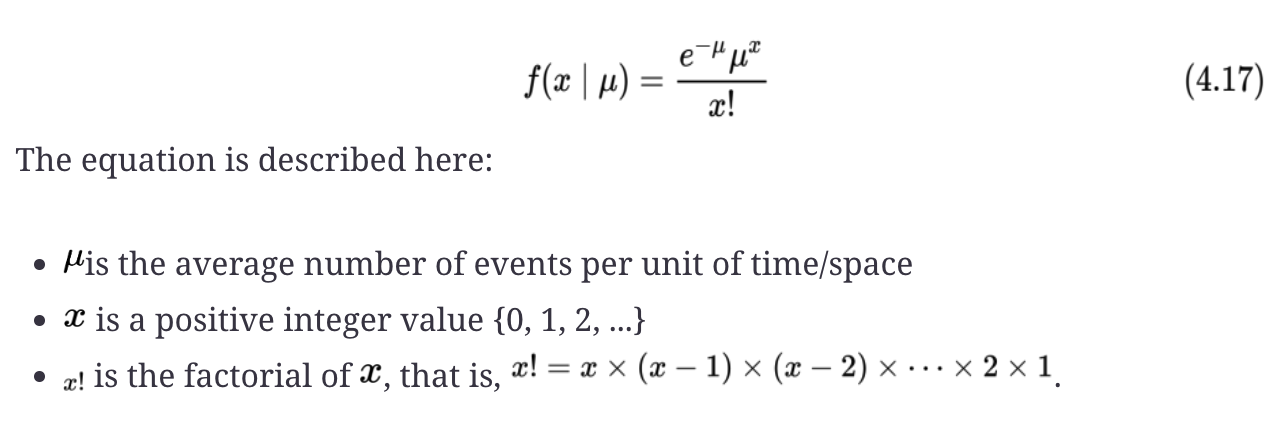

## Poisson Regression

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html

### Log Total Involved against Log Republican Spending

#### Full Data Set

In [32]:
#create model

with pm.Model() as pois_log:
    
    #define priors
    b0 = pm.Normal("intercept", mu = 0, sigma = 10)
    b1 = pm.Normal("log_rep", mu = 0, sigma = 10)

    #define logistic model
    log_lambda = (b0 + b1*df['log_rep'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df['log_inv'].values)

In [33]:
#sample model
with pois_log:
    test = pm.sample(2000, init='adapt_diag', tune = 2000, target_accept = 0.95)# start= {'Intercept': np.array([0.225]), 'republican': np.array([10000000.])})
    pm.model_to_graphviz(pois_log).view()

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_rep, intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


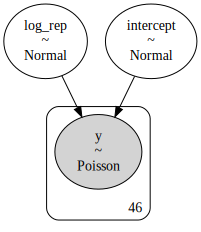

In [34]:
pm.model_to_graphviz(pois_log)

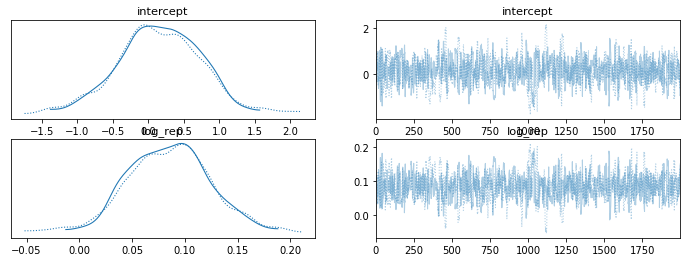

In [35]:
with pois_log:
    az.plot_trace(test)

In [36]:
#with pois_log:
az.summary(test)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.155,0.585,-0.981,1.196,0.022,0.020,703.0,502.0,1.0
log_rep,0.085,0.039,0.019,0.163,0.001,0.001,702.0,474.0,1.0


#### Dataset removing Illinois

In [37]:
#create model

with pm.Model() as pois_log2:
    
    #define priors
    b0 = pm.Normal("intercept", mu = 0, sigma = 10)
    b1 = pm.Normal("log_rep", mu = 0, sigma = 10)

    #define logistic model
    log_lambda = (b0 + b1*df_noutlier['log_rep'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df_noutlier['log_inv'].values)

In [38]:
#sample model
with pois_log2:
    test2 = pm.sample(2000, init='adapt_diag', tune = 2000, target_accept = 0.95)# start= {'Intercept': np.array([0.225]), 'republican': np.array([10000000.])})

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_rep, intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.


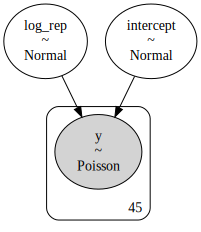

In [39]:
pm.model_to_graphviz(pois_log2)

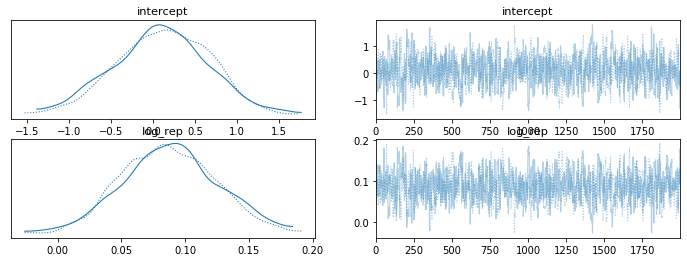

In [40]:
with pois_log2:
    az.plot_trace(test2)

In [41]:
#with pois_log:
az.summary(test2)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.105,0.549,-0.950,1.096,0.021,0.015,663.0,727.0,1.0
log_rep,0.088,0.037,0.022,0.158,0.001,0.001,666.0,724.0,1.0


Virtually no difference in mean coefficient values when removing Illinois from the data set

### Log Total Involved against Log Absolute Difference in Party Spending

In [42]:
#create model

with pm.Model() as pois_log_diff:
    
    #define priors
    b0 = pm.Normal("intercept", mu = 0, sigma = 10)
    b1 = pm.Normal("log_diff", mu = 0, sigma = 10)

    #define logistic model
    log_lambda = (b0 + b1*df['log_diff'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df['log_inv'].values)

In [43]:
#sample model
with pois_log_diff:
    test3 = pm.sample(2000, init='adapt_diag', tune = 2000, target_accept = 0.95)

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_diff, intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


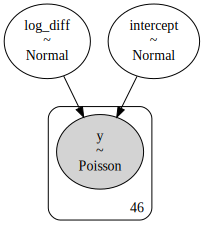

In [44]:
pm.model_to_graphviz(pois_log_diff)

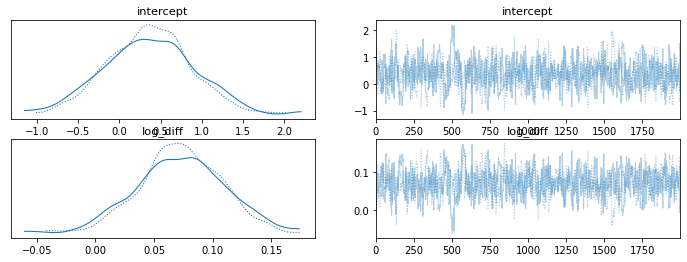

In [45]:
with pois_log_diff:
    az.plot_trace(test3)

In [46]:
#with pois_log_diff:
az.summary(test3)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.365,0.529,-0.620,1.365,0.025,0.021,459.0,496.0,1.01
log_diff,0.073,0.036,0.005,0.140,0.002,0.001,458.0,481.0,1.01


## Hierarchical

https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html

In [47]:
#df.info()

In [48]:
#subset
df2 = df[['party', 'log_inv', 'log_rep']]
#df2_no = df_noutlier[['party', 'log_inv', 'log_rep']]

In [49]:
#you get a warning if you do the top line
#df2['party'] = df2['party'].astype('category')

#do this one instead
df2 = df2.assign(party = df2.party.astype('category'))
#df2_no = df2_no.assign(party = df2_no.party.astype('category'))

In [50]:
df2.head()

,party,log_inv,log_rep
0,r,5.273000,14.105821
1,r,2.890372,12.287509
2,b,4.663439,17.933700
3,r,4.844187,13.301539
4,b,6.322565,15.986767


In [51]:
#df2_no.head()

In [52]:
#original df
party_idxs, parties = pd.factorize(df2.party)
coords = {
    "party": parties,
    "obs_id": np.arange(len(party_idxs)),
}

In [53]:
# 1 -> blue (dem) 
# 0 -> red (rep)
party_idxs

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1], dtype=int64)

In [54]:
#parties

In [55]:
#coords

## Log Total Involved against Log Repulican Spending

In [56]:
with pm.Model():
    party_idx = pm.Data("party_idx", party_idxs)
    #print(party_idx)

In [57]:
with pm.Model() as hierarchical_model:
    party_idx = pm.Data("party_idx", party_idxs)
    
    # Hyperparameters for groups (states)
    #mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    #sigma_b0 = pm.HalfNormal("sigma_b0", 5.0)
    #mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    #sigma_b1 = pm.HalfNormal("sigma_b1", 5.0)
    
    mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    sigma_b0 = pm.HalfNormal("sigma_b0", 100)
    mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    sigma_b1 = pm.HalfNormal("sigma_b1", 100)

    #b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = df2.log_inv.shape)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = df2.log_inv.shape)

    b0_offset = pm.Normal('b0_offset', mu= 0, sd= 1, shape = 2)
    b0 = pm.Deterministic("b0", mu_b0 + b0_offset*sigma_b0)
    
    b1_offset = pm.Normal('b1_offset', mu= 0, sd= 1, shape = 2)
    b1 = pm.Deterministic("b1", mu_b1 + b1_offset*sigma_b1)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = 2)

    #define logistic model
    #log_lambda = b0[party_idxs] + b1[party_idxs] * df2.log_rep.values 
    log_lambda = b0[party_idx] + b1[party_idx] * df2.log_rep.values 
        
    #Data Likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df2.log_inv) 

In [58]:
#pm.model_to_graphviz(hierarchical_model)

In [59]:
with hierarchical_model:
    step = pm.NUTS(target_accept = 0.95)
    trace = pm.sample(8000, init='adapt_diag', tune = 8000, step = step, return_inferencedata = False) 

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1_offset, b0_offset, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 2 chains for 8_000 tune and 8_000 draw iterations (16_000 + 16_000 draws total) took 1188 seconds.
There were 827 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8239084105317762, but should be close to 0.95. Try to increase the number of tuning steps.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


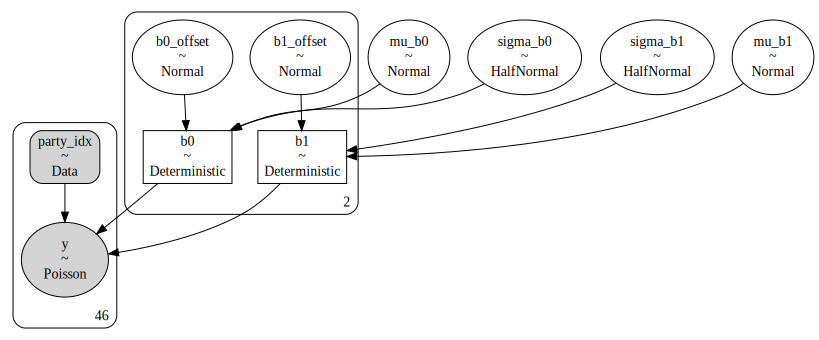

In [60]:
pm.model_to_graphviz(hierarchical_model)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b0_offset'}>,
        <AxesSubplot:title={'center':'b0_offset'}>],
       [<AxesSubplot:title={'center':'b1_offset'}>,
        <AxesSubplot:title={'center':'b1_offset'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b0'}>],
       [<AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>]], dtype=object)

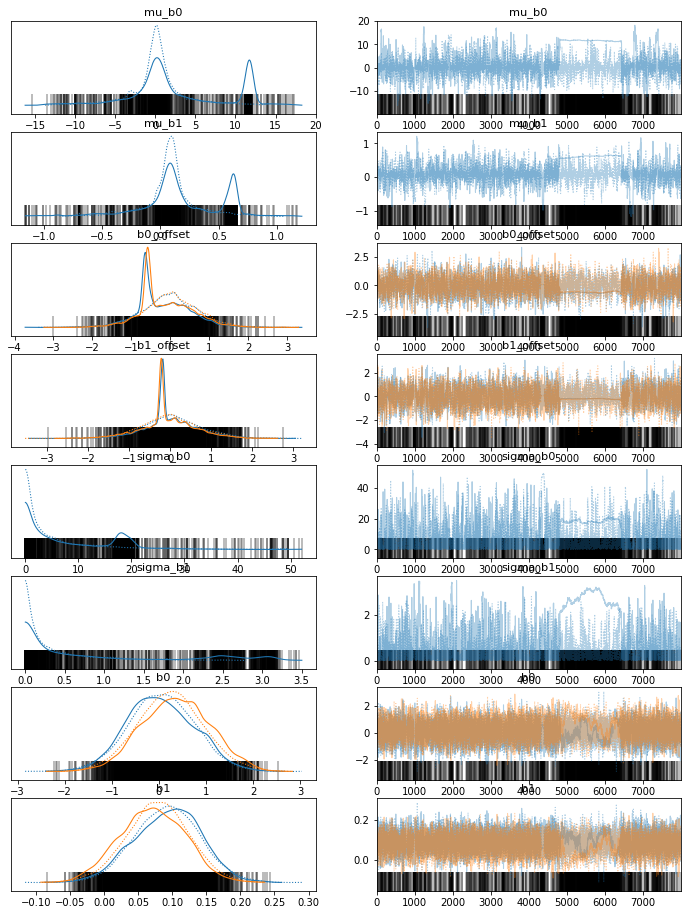

In [61]:
az.plot_trace(trace)

In [62]:
#az.plot_trace(trace, var_names=["mu_b0", "mu_b1", "sigma_b0", "sigma_b1"]);

In [63]:
pd.set_option('display.max_rows',None)

In [64]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b0,1.469,5.242,-6.797,12.028,1.384,1.082,22.0,62.0,1.08
mu_b1,0.129,0.301,-0.464,0.660,0.047,0.057,53.0,112.0,1.06
b0_offset[0],-0.118,0.726,-1.412,1.310,0.050,0.035,177.0,3026.0,1.02
b0_offset[1],-0.048,0.711,-1.402,1.294,0.052,0.037,173.0,2299.0,1.02
b1_offset[0],0.031,0.693,-1.316,1.390,0.017,0.016,1607.0,2611.0,1.01
b1_offset[1],-0.040,0.698,-1.353,1.387,0.016,0.015,1903.0,2266.0,1.02
sigma_b0,7.824,9.036,0.000,22.583,1.091,0.775,77.0,821.0,1.03
sigma_b1,0.658,0.874,0.000,2.640,0.249,0.182,22.0,31.0,1.09
b0[0],0.050,0.712,-1.246,1.394,0.021,0.015,1152.0,4457.0,1.00
b0[1],0.304,0.714,-1.040,1.647,0.049,0.035,214.0,330.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'b0_offset\n0'}>],
       [<AxesSubplot:title={'center':'b0_offset\n1'}>,
        <AxesSubplot:title={'center':'b1_offset\n0'}>,
        <AxesSubplot:title={'center':'b1_offset\n1'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'b0\n0'}>],
       [<AxesSubplot:title={'center':'b0\n1'}>,
        <AxesSubplot:title={'center':'b1\n0'}>,
        <AxesSubplot:title={'center':'b1\n1'}>]], dtype=object)

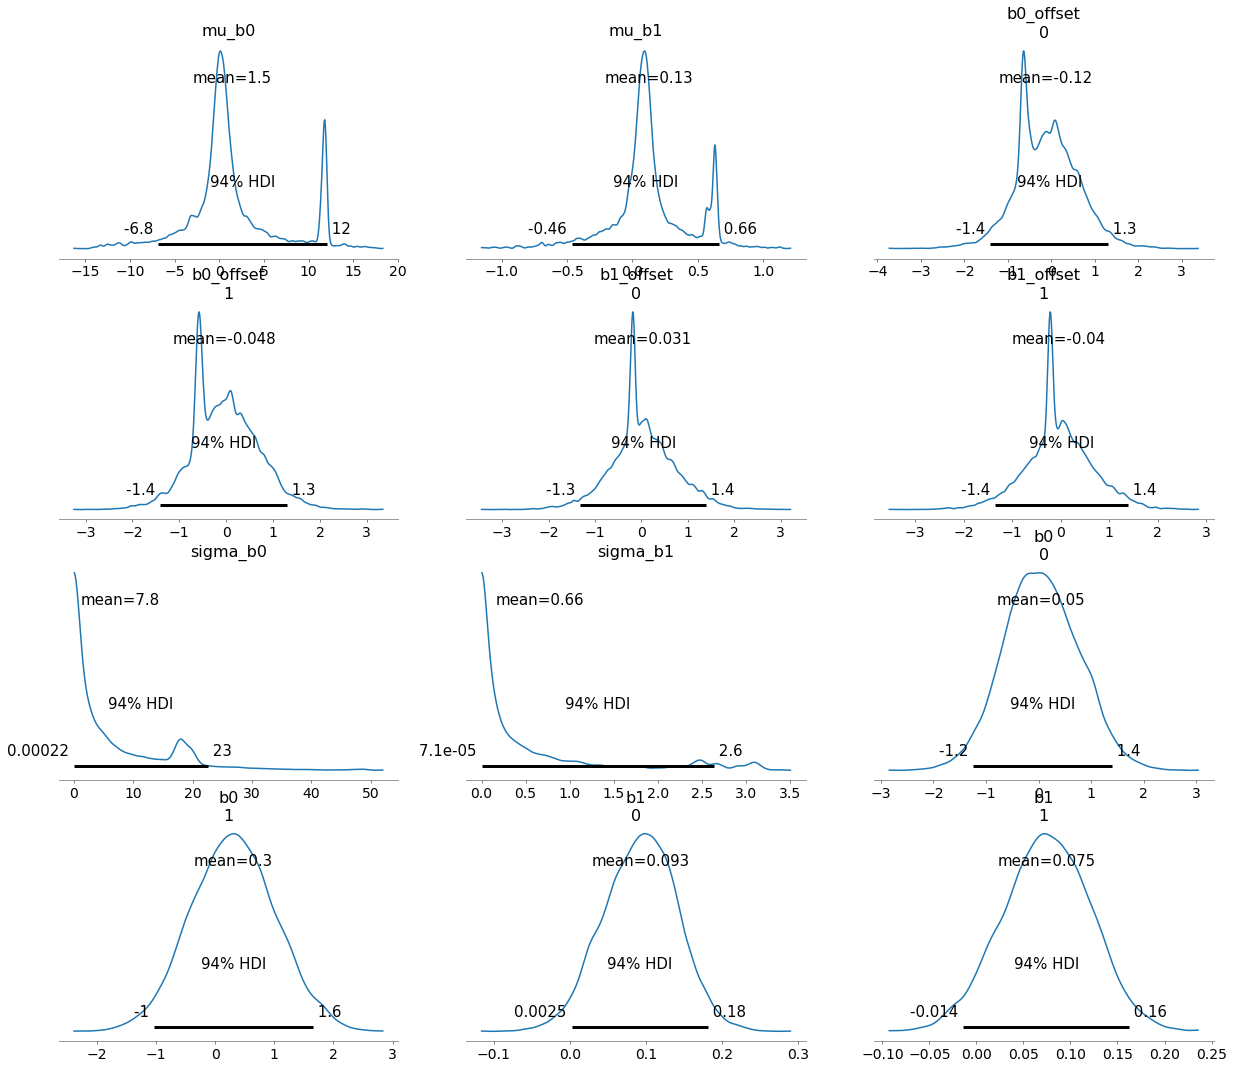

In [65]:
az.plot_posterior(trace) #var_names=["ab"])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<AxesSubplot:ylabel='mu_b1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='b0_offset\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b0_offset\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b1_offset\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b1_offset\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma_b0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSub

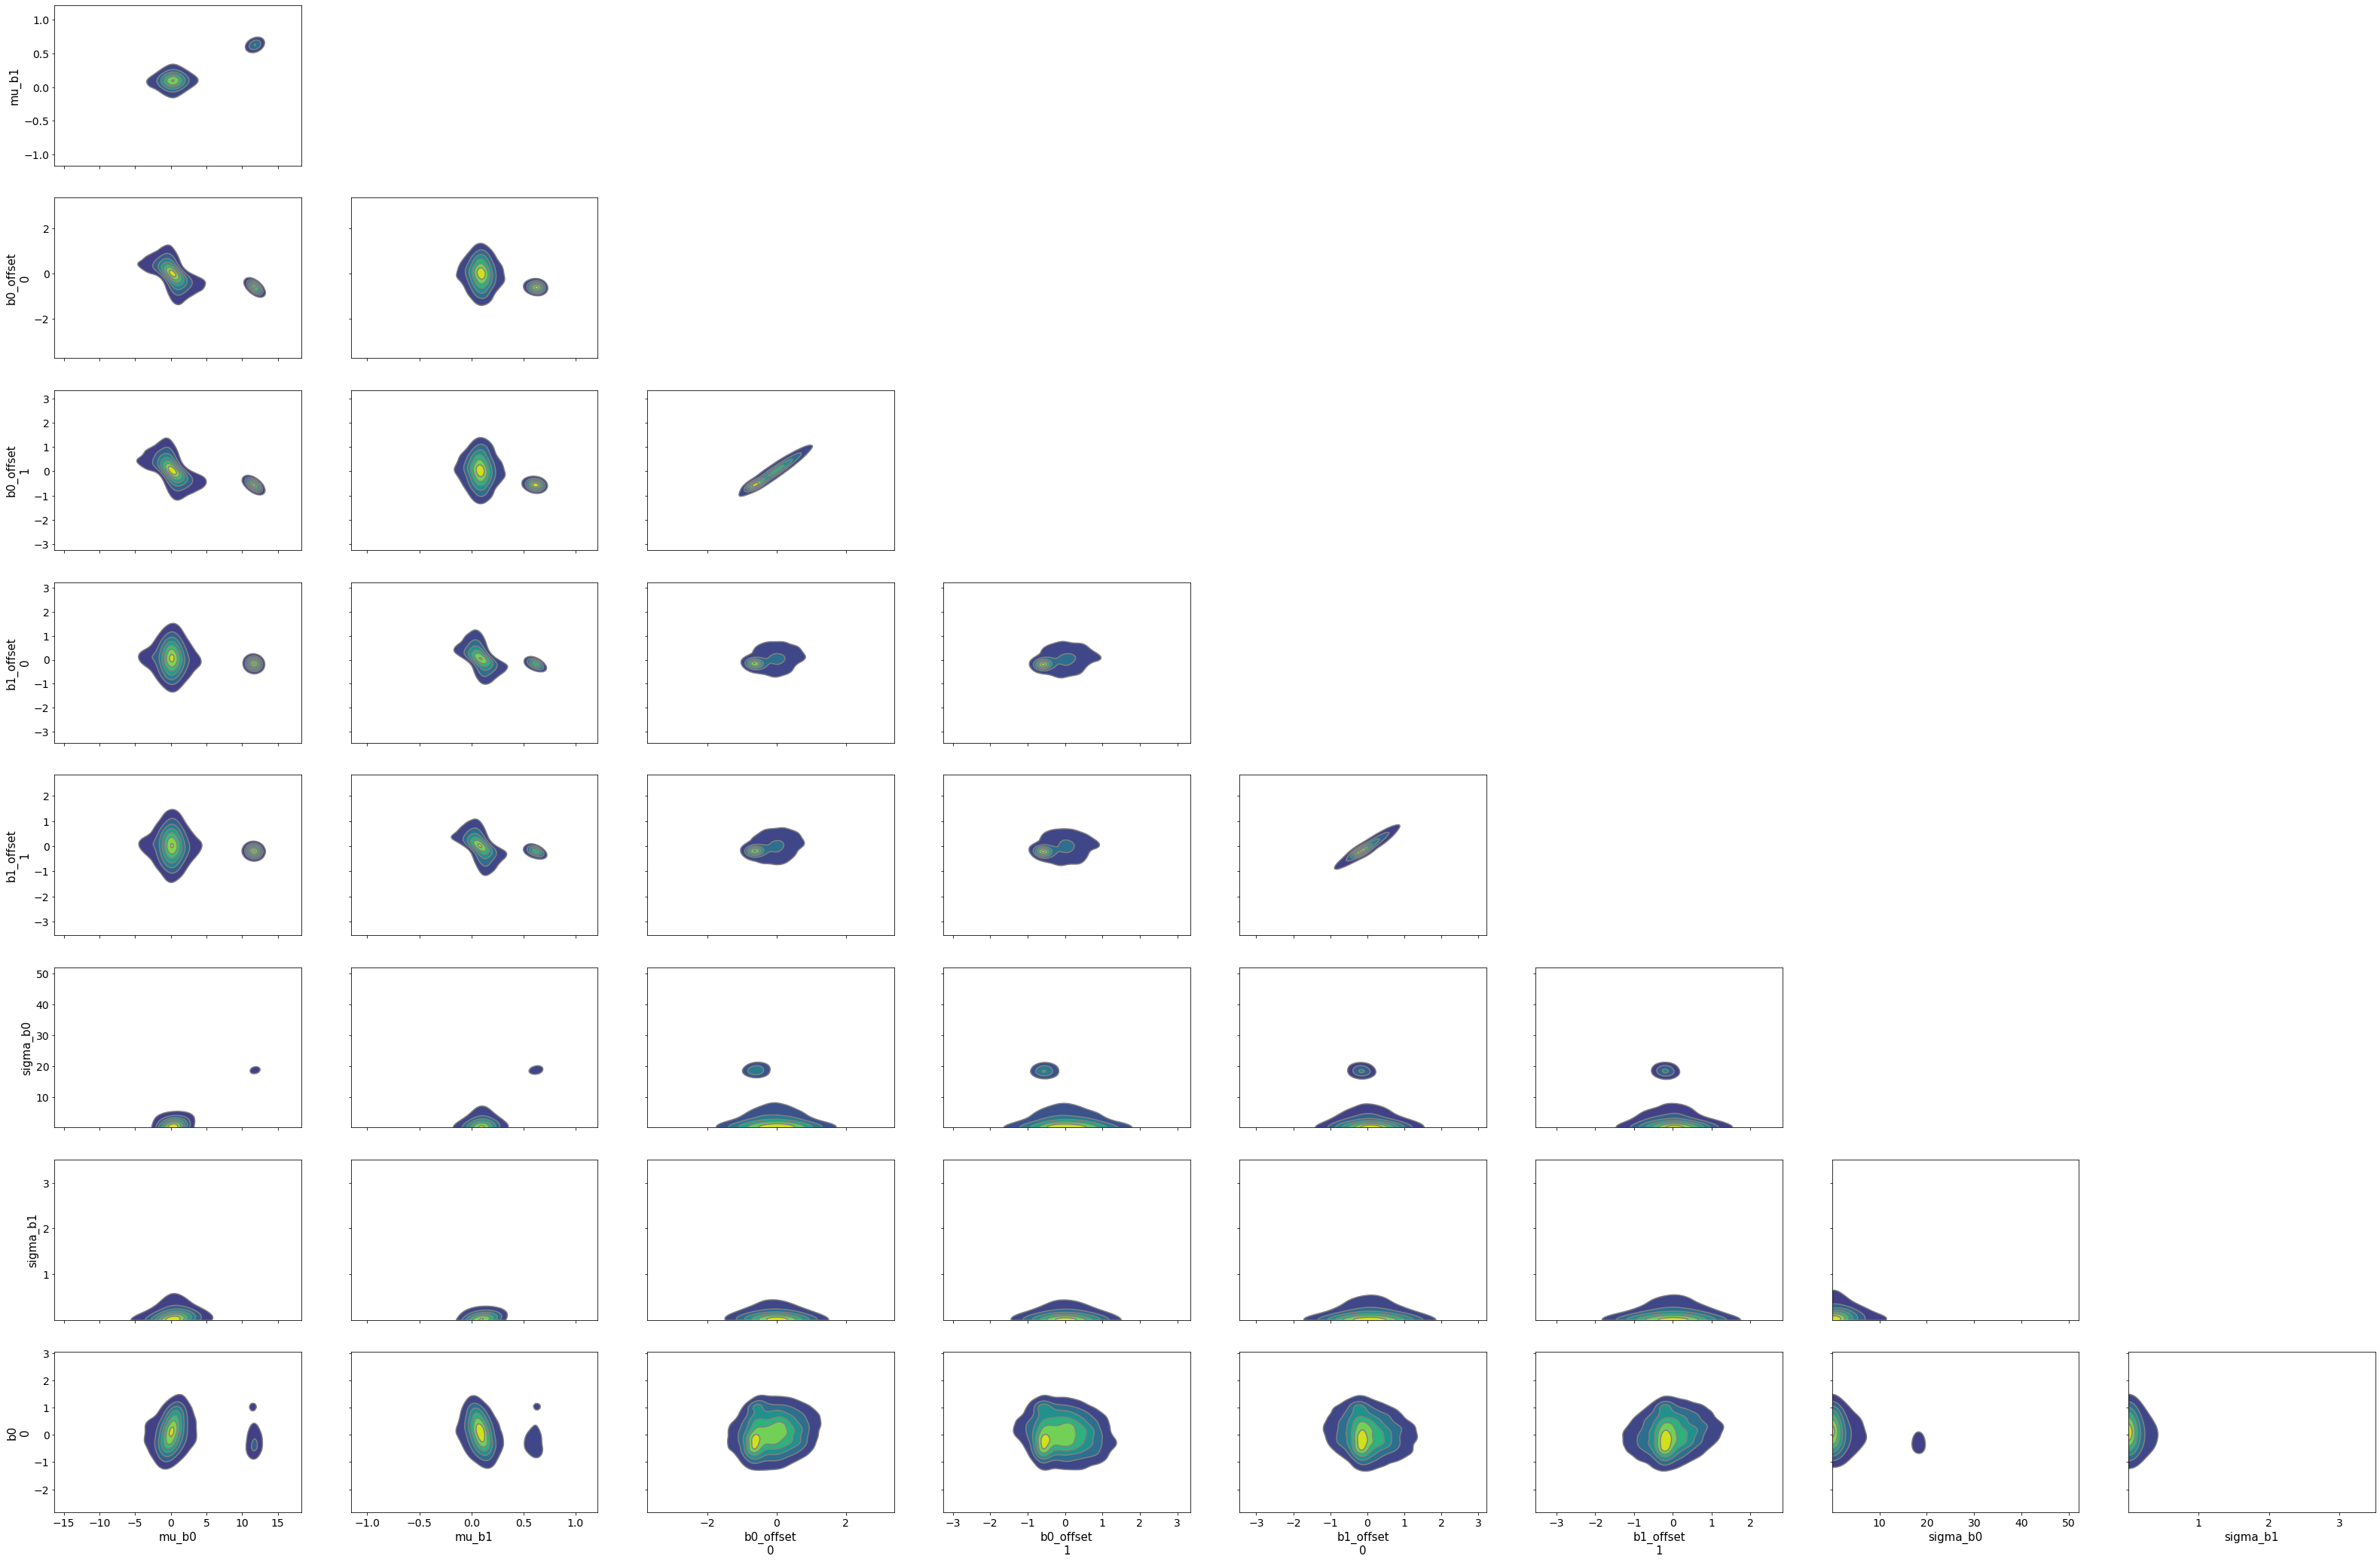

In [66]:
#az.plot_pair(trace, var_names=["X", "Z"], kind="kde")
az.plot_pair(trace, kind="kde")

### Log Total Involved against Log Absolute Difference in Political Spending

- still a bunch of diverences but the rhats look ok? 
- interesting result -> highed dem intercept but higher slope for repub

In [67]:
df3 = df[['party', 'log_inv', 'log_diff']]

In [68]:
#doesn't create a warning
df3 = df3.assign(party = df3.party.astype('category'))

In [69]:
df3.dtypes

party       category
log_inv      float64
log_diff     float64
dtype: object

In [70]:
df3.head(5)

,party,log_inv,log_diff
0,r,5.273000,13.766415
1,r,2.890372,11.695003
2,b,4.663439,17.194542
3,r,4.844187,12.473199
4,b,6.322565,14.459949


In [71]:
party_idxs3, parties3 = pd.factorize(df3.party)
coords3 = {
    "party3": parties3,
    "obs_id3": np.arange(len(party_idxs3)),
}

In [72]:
# 1 -> blue (dem) 
# 0 -> red (rep)
party_idxs3

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1], dtype=int64)

In [73]:
with pm.Model() as hierarchical_model_diff:
    party_idx3 = pm.Data("party_idx3", party_idxs3)
    
    # Hyperparameters for groups (states)
    #mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    #sigma_b0 = pm.HalfNormal("sigma_b0", 5.0)
    #mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    #sigma_b1 = pm.HalfNormal("sigma_b1", 5.0)
    
    mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    sigma_b0 = pm.HalfNormal("sigma_b0", 5)
    mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    sigma_b1 = pm.HalfNormal("sigma_b1", 5)

    #b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = df2.log_inv.shape)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = df2.log_inv.shape)
    b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = 2)
    b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = 2)
    
    #define logistic model
    #log_lambda = b0[party_idxs] + b1[party_idxs] * df2.log_rep.values 
    log_lambda = b0[party_idx3] + b1[party_idx3] * df3.log_diff.values 
        
    #Data Likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df3.log_inv) 

In [74]:
with hierarchical_model_diff:
    step3 = pm.NUTS(target_accept = 0.95)
    trace3 = pm.sample(8000, init='adapt_diag', tune = 8000, step = step3, return_inferencedata = False) 

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1, b0, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 2 chains for 8_000 tune and 8_000 draw iterations (16_000 + 16_000 draws total) took 218 seconds.
There were 406 divergences after tuning. Increase `target_accept` or reparameterize.
There were 566 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


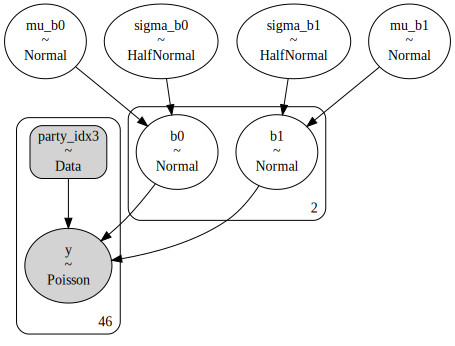

In [75]:
pm.model_to_graphviz(hierarchical_model_diff)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b0'}>],
       [<AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>]], dtype=object)

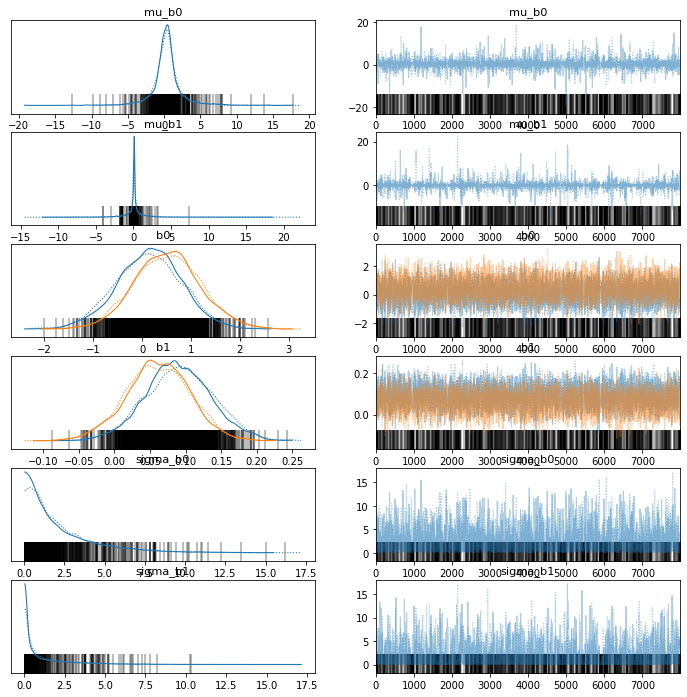

In [76]:
az.plot_trace(trace3)

In [77]:
az.summary(trace3)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b0,0.388,2.148,-3.871,4.555,0.050,0.039,2299.0,2069.0,1.00
mu_b1,0.097,1.690,-3.138,3.075,0.037,0.029,3634.0,2366.0,1.00
b0[0],0.140,0.670,-1.181,1.335,0.012,0.008,3362.0,5630.0,1.00
b0[1],0.511,0.678,-0.719,1.826,0.013,0.009,2840.0,3037.0,1.00
b1[0],0.090,0.047,-0.001,0.178,0.001,0.001,3441.0,5551.0,1.00
b1[1],0.061,0.045,-0.026,0.143,0.001,0.001,2836.0,3479.0,1.00
sigma_b0,2.166,2.170,0.030,6.293,0.048,0.034,1288.0,1058.0,1.00
sigma_b1,1.356,1.932,0.022,5.033,0.044,0.031,844.0,77.0,1.01


# 3. Testing

Models:  
- pois_log: test
- pois_log_diff: test3
- hierarchical_model: trace
- hierarchical_model_diff: trace3

## WAIC

In [78]:
with pois_log:
    pois_log_waic = pm.waic(test)
pois_log_waic

Computed from 4000 posterior samples and 46 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -84.35     1.61
p_waic        0.63        -

In [79]:
with pois_log_diff:
    pois_log_diff_waic = pm.waic(test3)
pois_log_diff_waic

Computed from 4000 posterior samples and 46 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -84.92     1.85
p_waic        0.66        -

In [80]:
with hierarchical_model:
    hierarchical_model_waic = pm.waic(trace)
hierarchical_model_waic

Computed from 16000 posterior samples and 46 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -85.29     1.64
p_waic        1.15        -

In [81]:
with hierarchical_model_diff:
    hierarchical_model_waic3 = pm.waic(trace3)
hierarchical_model_waic3

Computed from 16000 posterior samples and 46 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -85.71     1.83
p_waic        1.16        -

## LOOC

In [82]:
with pois_log:
    pois_log_loo = az.loo(test)
pois_log_loo

Computed from 4000 posterior samples and 46 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -84.35     1.61
p_loo        0.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [83]:
with pois_log_diff:
    pois_log_diff_loo = az.loo(test3)
pois_log_diff_loo

Computed from 4000 posterior samples and 46 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -84.92     1.85
p_loo        0.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [84]:
with hierarchical_model:
    hierarchical_model_loo = az.loo(trace)
hierarchical_model_loo

C:\Users\fav21\anaconda3\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 16000 posterior samples and 46 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -85.30     1.64
p_loo        1.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [85]:
with hierarchical_model_diff:
    hierarchical_model_diff_loo = az.loo(trace3)
hierarchical_model_diff_loo

Computed from 16000 posterior samples and 46 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -85.72     1.83
p_loo        1.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Comparison

https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html

In [86]:
compare_dict = {"hierarchical": trace, "poisson_regression": test}
df_comp_waic = az.compare(compare_dict, ic = 'waic')
df_comp_waic

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
poisson_regression,0,-84.347345,0.632399,0.000000,1.0,1.612234,0.000000,False,log
hierarchical,1,-85.293207,1.151095,0.945862,0.0,1.639663,0.172449,False,log


In [87]:
compare_dict = {"hierarchical": trace, "poisson_regression": test}
df_comp_loo = az.compare(compare_dict, ic = 'loo')
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\fav21\anaconda3\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  wa

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
poisson_regression,0,-84.350173,0.635227,0.000000,1.0,1.612291,0.000000,False,log
hierarchical,1,-85.304770,1.162657,0.954596,0.0,1.640255,0.175197,False,log


**I don't see a difference in values between loo and waic**

In [ ]:
compare_dict = {"hierarchical": trace, "hierarchical_diff": trace3, "poisson_regression": test, "poisson_regression_diff": test3}
df_comp_waic = az.compare(compare_dict, ic = 'waic')
df_comp_waic

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


**I THINK poisson_regression is the best model.** This code 'ranks' the models from from 0 (best model) ot the number of models. The loo values are therefore also always sorted from best LOO/WAIC to worst. Warnings are false (if they were true then LOO/WAIC may not be reliable). 

## Posterior Predictive Check: Root Mean Square Deviation (RMSD)

https://discourse.pymc.io/t/glm-hierarchical-linear-regression-posterior-predictive-check-rmsd/5668

In [ ]:
with pois_log:
    pois_log_ppc = pm.sample_posterior_predictive(test)

pois_log_rmse = ((pois_log_ppc['y'] - df.log_inv.values) ** 2).mean() ** (1/2)

In [ ]:
pois_log_rmse

In [ ]:
with pois_log_diff:
    pois_log_diff_ppc = pm.sample_posterior_predictive(test3)

pois_log_diff_rmse = ((pois_log_diff_ppc['y'] - df.log_inv.values) ** 2).mean() ** (1/2)

In [ ]:
pois_log_diff_rmse

In [ ]:
with hierarchical_model:
    hm_ppc = pm.sample_posterior_predictive(trace)

hm_rmse = ((hm_ppc['y'] - df2.log_inv.values) ** 2).mean() ** (1/2)
hm_rmse

In [ ]:
hm_ppc

In [ ]:
with hierarchical_model_diff:
    hm_diff_ppc = pm.sample_posterior_predictive(trace3)

hm_diff_rmse = ((hm_diff_ppc['y'] - df3.log_inv.values) ** 2).mean() ** (1/2)
hm_diff_rmse

**Same results with RMSD. Poisson regression using republican spending produced best results with the smallest RMSD**